# **1. Imports**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix
)

from sklearn.metrics import confusion_matrix

# **2. Loading Data & Merging**

## **2.1 Loading Train Data**

In [ ]:
# Load full column list without loading full data
all_columns = pd.read_csv('train_transaction.csv', nrows=0).columns.tolist()

# Define which D columns you want to keep
keep_D_cols = ['D1', 'D2', 'D3', 'D5', 'D6','D9', 'D10', 'D11', 'D15']

# Define which V columns to keep (based on your numbers)
V_numbers = [
    1, 3, 4, 6, 8, 11, 13, 14, 17, 20, 22, 23, 26, 27, 30, 36, 37,
    40, 41, 42, 44, 47, 48, 52, 54, 59, 62, 63, 65, 67, 68, 70, 76, 78, 80, 82, 84, 86, 88, 89, 91, 99,
    127, 165, 203, 180, 218, 307, 296, 332,
    108, 109, 111, 114, 115, 117, 118, 120, 121, 123, 124, 129,
    130, 131, 136, 138, 139, 142, 143, 150, 147, 155, 160, 162,
    165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 185,
    190, 187, 188, 195, 198, 201,
    205, 206, 207, 208, 209, 210, 216, 220,
    221, 223, 224, 226, 227, 228, 229, 238,
    240, 241, 242, 243, 245, 246, 248, 249, 250, 253, 256, 258, 259, 260,
    263, 264, 266, 267, 269, 270, 271, 272, 273, 274, 275, 276,
    280, 283, 285, 286, 287, 289, 291, 301, 303,
    309, 313, 310, 320,325,335,338
]
keep_V_cols = [f'V{num}' for num in V_numbers]

# Build final list: all non-D/V columns + selected D + selected V
other_cols = [col for col in all_columns if not col.startswith('D') and not col.startswith('V')]
selected_columns = other_cols + keep_D_cols + keep_V_cols

# Load only those selected columns
train_transactionDf = pd.read_csv('train_transaction.csv', usecols=selected_columns)

num_features = train_transactionDf.shape[1]

# Alternatively, you can use len() on the columns
num_features = len(train_transactionDf.columns)
print(num_features)


198


## **2.2 Merging with another training identity data**

In [ ]:
train_identity = pd.read_csv('train_identity.csv')
train_df = train_transactionDf.merge(train_identity, on='TransactionID', how='left')

num_features = len(train_df.columns)
print("Number of Features: ",num_features)

num_columns = train_df.columns
chunk_size = 10


# Loop through and display columns in chunks
for i in range(0, len(num_columns), chunk_size):
    chunk = num_columns[i:i+chunk_size]
    print(f"🔹 Chunk {i//chunk_size + 1}: {list(chunk)}\n")

Number of Features:  238
🔹 Chunk 1: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5']

🔹 Chunk 2: ['card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3']

🔹 Chunk 3: ['C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13']

🔹 Chunk 4: ['C14', 'D1', 'D2', 'D3', 'D5', 'D6', 'D9', 'D10', 'D11', 'D15']

🔹 Chunk 5: ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1']

🔹 Chunk 6: ['V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17', 'V20', 'V22']

🔹 Chunk 7: ['V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41', 'V42', 'V44']

🔹 Chunk 8: ['V47', 'V48', 'V52', 'V54', 'V59', 'V62', 'V63', 'V65', 'V67', 'V68']

🔹 Chunk 9: ['V70', 'V76', 'V78', 'V80', 'V82', 'V84', 'V86', 'V88', 'V89', 'V91']

🔹 Chunk 10: ['V99', 'V108', 'V109', 'V111', 'V114', 'V115', 'V117', 'V118', 'V120', 'V121']

🔹 Chunk 11: ['V123', 'V124', 'V127', 'V129', 'V130', 'V131', 'V136', 'V138', 'V139'

## **2.3 Encoding Train Data**

In [ ]:
# Identify numeric & categorical columns
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

# Convert all numeric features to float (XGBoost prefers float)
train_df[numeric_cols] = train_df[numeric_cols].astype("float")

# Function to encode categorical features
def encode_LE(col, df):
    """Label Encodes a categorical column and optimizes memory usage."""
    df_comb, _ = df[col].factorize(sort=True)  # Factorize sorts values before encoding
    if df_comb.max() > 32000:
        df[col] = df_comb.astype("int32")
    else:
        df[col] = df_comb.astype("int16")
    del df_comb
    gc.collect()  # Free up memory

# Encode categorical features with few unique values using Label Encoding
label_enc_cols = [col for col in categorical_cols if train_df[col].nunique() < 20]  # Threshold: 20 unique values

for col in label_enc_cols:
    train_df[col] = train_df[col].fillna("Missing")  # Handle missing values
    encode_LE(col, train_df)

# Encode high-cardinality categorical features using Target Encoding
target_enc_cols = [col for col in categorical_cols if col not in label_enc_cols]

for col in target_enc_cols:
    fraud_mean = train_df.groupby(col)["isFraud"].mean()  # Mean target encoding
    train_df[col] = train_df[col].map(fraud_mean)  # Replace categories with mean fraud probability
    train_df[col].fillna(train_df["isFraud"].mean(), inplace=True)  # Fill missing values

print(train_df.dtypes)


<ipython-input-7-afbb7dc2ab71>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df["isFraud"].mean(), inplace=True)  # Fill missing values
<ipython-input-7-afbb7dc2ab71>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].m

TransactionID     float64
isFraud           float64
TransactionDT     float64
TransactionAmt    float64
ProductCD           int16
                   ...   
id_36               int16
id_37               int16
id_38               int16
DeviceType          int16
DeviceInfo        float64
Length: 238, dtype: object


<ipython-input-7-afbb7dc2ab71>:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[col].fillna(train_df["isFraud"].mean(), inplace=True)  # Fill missing values


# **Train On XGBoost**
Why XGBoost?
* Data has many missing values in most of the features by which XGBoost handles them.
* Wide variations in the values of features which may be essential to indicate a fraudulent transaction. We need to avoid normalization but maintain a good classification(done by XGBoost).

## **Train + Validate**

In [ ]:
#  Prepare features and target
X = train_df.drop(["isFraud", "TransactionID", "TransactionDT"], axis=1)
y = train_df["isFraud"]

#  Split into Train (70%), Validation (15%), Test (15%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1765, stratify=y_train_full, random_state=42
)
# 0.1765 ensures ~15% validation of the full original dataset

print(f"🧪 Shapes ➤ Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

#  Handle class imbalance
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1

#  Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)  # for later prediction

#  Define XGBoost training parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": ["auc", "aucpr"],
    "learning_rate": 0.1,
    "max_depth": 10,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "scale_pos_weight": scale_pos_weight,
    "seed": 42,
    "nthread": -1
}

#  Train with early stopping
watchlist = [(dtrain, "train"), (dval, "eval")]

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=watchlist,
    early_stopping_rounds=20,
    verbose_eval=True
)

#  Evaluate on validation set
y_pred_proba = bst.predict(dval)
y_pred = (y_pred_proba >= 0.5).astype(int)

print("\n🔍 ROC AUC Score:", roc_auc_score(y_val, y_pred_proba))
print("📈 PR AUC (Average Precision):", average_precision_score(y_val, y_pred_proba))
print("\n🧾 Classification Report:\n", classification_report(y_val, y_pred))


🧪 Shapes ➤ Train: (413363, 235), Val: (88596, 235), Test: (88581, 235)
[0]	train-auc:0.89045	train-aucpr:0.44899	eval-auc:0.86641	eval-aucpr:0.43315
[1]	train-auc:0.91419	train-aucpr:0.53352	eval-auc:0.89317	eval-aucpr:0.50477
[2]	train-auc:0.92439	train-aucpr:0.56564	eval-auc:0.90304	eval-aucpr:0.52747
[3]	train-auc:0.92844	train-aucpr:0.58746	eval-auc:0.90739	eval-aucpr:0.54188
[4]	train-auc:0.93212	train-aucpr:0.59680	eval-auc:0.90958	eval-aucpr:0.55217
[5]	train-auc:0.93400	train-aucpr:0.60474	eval-auc:0.91011	eval-aucpr:0.55603
[6]	train-auc:0.93551	train-aucpr:0.61178	eval-auc:0.91117	eval-aucpr:0.56317
[7]	train-auc:0.93748	train-aucpr:0.62021	eval-auc:0.91238	eval-aucpr:0.57266
[8]	train-auc:0.93927	train-aucpr:0.62529	eval-auc:0.91273	eval-aucpr:0.57594
[9]	train-auc:0.94096	train-aucpr:0.63121	eval-auc:0.91469	eval-aucpr:0.58069
[10]	train-auc:0.94235	train-aucpr:0.63622	eval-auc:0.91587	eval-aucpr:0.58349
[11]	train-auc:0.94314	train-aucpr:0.64006	eval-auc:0.91642	eval-aucpr

## **Test**


 [Final Test Evaluation]
🔍 ROC AUC Score (Test): 0.9706454451227233
📈 PR AUC (Average Precision - Test): 0.8589881657064362

🧾 Classification Report (Test):
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     85482
         1.0       0.91      0.74      0.82      3099

    accuracy                           0.99     88581
   macro avg       0.95      0.87      0.91     88581
weighted avg       0.99      0.99      0.99     88581



<ipython-input-9-ca2be2ee9430>:24: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


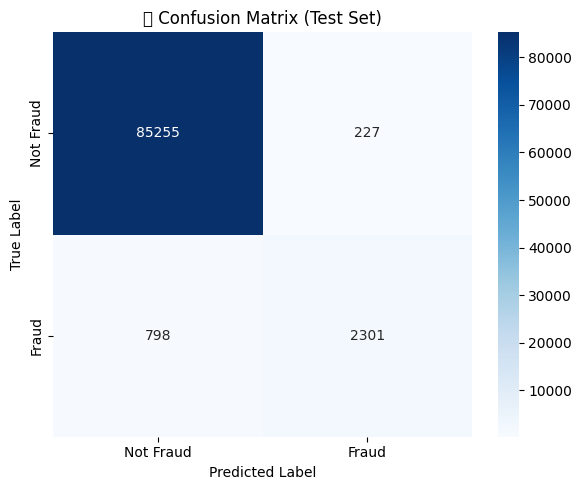

In [ ]:
# Evaluate on the Test Set

# Predict probabilities for test set
y_test_proba = bst.predict(dtest)
y_test_pred = (y_test_proba >= 0.5).astype(int)

# Print evaluation metrics
print("\n [Final Test Evaluation]")
print("🔍 ROC AUC Score (Test):", roc_auc_score(y_test, y_test_proba))
print("📈 PR AUC (Average Precision - Test):", average_precision_score(y_test, y_test_proba))
print("\n🧾 Classification Report (Test):\n", classification_report(y_test, y_test_pred))


# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
labels = ["Not Fraud", "Fraud"]

# Plot it
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("🧾 Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


# **Why Use AUC and AUC-PR Metrics in Fraud Detection?**
### **🔹 What is AUC?**
AUC (Area Under the ROC Curve) measures a model’s ability to distinguish between positive and negative classes across all classification thresholds.
It plots the True Positive Rate (Recall) vs. False Positive Rate.
AUC ranges from 0.5 (random guessing) to 1.0 (perfect classification).

### **Why AUC is Useful**


*  **Threshold-independent:** AUC evaluates performance across all thresholds, not just at 0.5, so you get a holistic view of the model's ranking power.
*  **Class-imbalance friendly:** Unlike accuracy, AUC is not biased by the dominant class. In fraud detection, predicting all zeros (non-fraud) might give high accuracy but meaningless performance — AUC avoids this trap.
*  **Interpretability:**
AUC represents the probability that a randomly chosen positive (fraud) instance ranks higher than a randomly chosen negative one.







---






### **🔸 What is AUC-PR (PR AUC)?**
AUC-PR (Area Under the Precision-Recall Curve) focuses specifically on the positive class (fraud).
It plots Precision vs. Recall across thresholds.
Especially useful when positives are rare, and you care more about minimizing false positives while catching as many true frauds as possible.

### **Why AUC-PR is Better**
* **Zeroes in on positives:**
PR AUC focuses only on how well the model identifies the minority class — exactly what matters in fraud detection.

* **Sensitive to false positives:**
Precision drops when you predict too many false frauds. This is important in real-world fraud systems where false alerts are costly.

* **Reveals trade-off:**
It helps you visualize how increasing recall (catching more frauds) might hurt precision (more false alarms), which is a critical trade-off in practice.


---


### **🎯 Final Conslusion**
In fraud detection, it's best to track both AUC and AUC-PR:


*   Use AUC to understand the model’s overall discriminative power.
*   Use AUC-PR to evaluate its practical effectiveness in detecting actual fraud cases among a sea of legitimate ones.

Both together give a more complete picture of performance.




# **Model Performance Summary**

The model demonstrated excellent performance overall. During training, it achieved a **ROC AUC of 0.972** and a **PR AUC of 0.871**, showing strong learning capability and effective separation between fraud and non-fraud classes.


On the test set, the model maintained consistent generalization, achieving a **ROC AUC of 0.971** and a **PR AUC (Average Precision) of 0.859**, indicating robust discrimination between classes even on unseen data.

The model reached **99% accuracy** on the test set. For the fraud class (1):

**Precision:** 0.91

**Recall:** 0.74

**F1-score:** 0.82

These metrics highlight the model’s effectiveness in identifying a substantial proportion of fraudulent activity while keeping false positives relatively low.

Despite the significant class imbalance, the model maintains strong minority class (fraud) performance. The high precision ensures that flagged frauds are likely to be correct, and the solid recall ensures that a large portion of fraud cases are successfully caught. This balance is particularly important in real-world fraud detection scenarios, where missing fraud (false negatives) can be far more costly than false alarms (false positives).